In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from IPython.display import clear_output
import numpy as np
from utils import MLP, train_BG
import matplotlib.pyplot as plt


In [3]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 1.1 RealNVP layer

In [36]:
class RealNVPLayer(nn.Module):
    """Transform a batch of two dimensional prior sample
    Args:

    """
    def __init__(self,
                 unchanged_indices, 
                 dim_layers=3, 
                 dim_nodes=48):
        

        super().__init__()
        self.unchanged_indices = unchanged_indices
        self.s_theta = MLP(n_units=[1] + [dim_nodes]*dim_layers +[1])
        self.t_theta = MLP(n_units=[1] + [dim_nodes]*dim_layers +[1])


    def forward(self, z):
        z1, z2 = torch.split(z, [len(self.unchanged_indices), z.size(1) - len(self.unchanged_indices)], dim=1)
        x1 = z1
        x2 = z2 * torch.exp(self.s_theta(z1)) + self.t_theta(z1)        
        x = torch.cat([x1, x2], dim=1)
        
        return x, self.s_theta, self.t_theta

In [81]:
### not sure how to test

from torch.autograd.functional import jacobian

a_RealNVPLayer = RealNVPLayer(unchanged_indices=[0])
z_samples = torch.randn(10, 2)
x, s_theta, t_theta = a_RealNVPLayer.forward(z_samples)


def transform(z):
    x1 = z[:, 0:1]
    x2 = z[:, 1:2] * torch.exp(s_theta(x1)) + t_theta(x1)
    return torch.cat([x1, x2], dim=1)


jacobi = jacobian(func=transform, inputs=z_samples)
print(jacobi.shape)
# batch_size, _, _, _ = jacobi.shape
# jacobi = jacobi.view(batch_size, 2, 2)
# print(jacobi.shape)
# torch.det(jacobi)
# # print(s_theta(z_samples[:, 0:1]).shape)

torch.Size([10, 2, 10, 2])


## 1.2 Coupling Flow

Affine transformation

In [4]:
def affine_transform_forward(
    changed, fixed, shift_transformation, scale_transformation
):
    """
    Affine transformation.

    Parameters:
    -----------
    changed: Configuration part to be changed of shape [batch_size, 1].

    fixed: Configuration part to be conditioned on of shape [batch_size, 1].

    shift_transformation: Neural network (pytorch model)

    scale_transformation: Neural network (pytorch model)

    """
    mu = shift_transformation(fixed)

    # we add a tanh for numerical stability
    log_sigma = torch.tanh(scale_transformation(fixed))

    sigma = torch.exp(log_sigma)

    changed = changed * sigma + mu
    log_det_jac = log_sigma

    return changed, log_det_jac

Let's look at an example of this affine transformation:

In [7]:
net_scale = MLP([1,12,12,1])
net_shift = MLP([1,12,12,1])

In [5]:
pos = torch.arange(24.).reshape(12,2)
id_fixed, id_changed = 0,1

In [8]:
changed, ldj = affine_transform_forward(
    pos[:, [id_changed]], pos[:, [id_fixed]], net_shift, net_scale
)

In [55]:
changed.shape, ldj.shape


(torch.Size([12, 1]), torch.Size([12, 1]))

We build the transformed array

In [56]:
new_pos = torch.zeros_like(pos)
new_pos[:,[id_changed]] = changed
new_pos[:,[id_fixed]] =  pos[:, [id_fixed]]

In [57]:
torch.allclose(new_pos[:, id_changed], pos[:, id_changed])

False

In [58]:
torch.allclose(new_pos[:, id_fixed], pos[:, id_fixed])

True

Coupling layer consisting of an affine transformation

In [9]:
class CouplingLayer(torch.nn.Module):

    def __init__(self, fixed_id, changed_id):
        """
        Coupling layer.

        Parameters:
        -----------
        pos: Configuration of shape [batch_size, 2].

        """

        super().__init__()
        self.fixed_id = fixed_id
        self.changed_id = changed_id

        self.net_translate = MLP([1,64,64,64,1]).to(DEVICE)
        self.net_scale = MLP([1,64,64,64,1]).to(DEVICE)

    def forward(self, pos):
        """
        Forward coupling.

        Parameters:
        -----------
        pos: Configuration of shape [batch_size, 2].

        Returns:
        -----------
        new_pos: Transformed configuration of shape [batch_size, 2].

        log_det_jacobian: Jacobian of the transformations of shape [batch_size,].

        """

        changed, log_det_jacobian = affine_transform_forward(pos[:, [self.changed_id]], pos[:, [self.fixed_id]], self.net_translate, self.net_scale)

        new_pos = torch.zeros_like(pos)
        new_pos[:,[self.changed_id]] = changed
        new_pos[:,[self.fixed_id]] =  pos[:, [self.fixed_id]]

        return new_pos, log_det_jacobian

In [12]:
from torch.autograd.functional import jacobian

id_fixed, id_changed = 0,1
net_scale = MLP([1,12,12,1])
net_shift = MLP([1,12,12,1])
net_shift_tensor = net_shift(pos[:, [id_fixed]])
net_scale_tensor = net_scale(pos[:, [id_fixed]])

a_coupling_layer = CouplingLayer(fixed_id=0, changed_id=1)
new_pos, log_det_jacobian = a_coupling_layer.forward(pos)

jacobi = jacobian(a_coupling_layer.forward, pos)

# print(jacobi)
print(jacobi[0][0,:,0,:])

print(log_det_jacobian)

(tensor([[[[ 1.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[-0.0901,  0.9842],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000],
          [ 1.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
   

Coupling flow consisting of multiple coupling layers

In [10]:
import itertools

class CouplingFlow(torch.nn.Module):
    def __init__(
        self,
        num_coupling_blocks: int,
    ):
        super().__init__()
        self.blocks = torch.nn.ModuleList()

        # add coupling layers using self.blocks.append()
        # for _ in range(num_coupling_blocks):
        #     self.blocks.append(CouplingLayer(fixed_id=0, changed_id=1))

        permutations = list(itertools.permutations([0,1]))

        for _ in range(num_coupling_blocks):
            for fixed_idxs, changed_idxs in permutations:
                self.blocks.append(
                    CouplingLayer(fixed_id=fixed_idxs,changed_id=changed_idxs
                    )
                )


    def forward(self, pos):
        """
        Forward coupling.

        Parameters:
        -----------
        pos: Configuration of shape [batch_size, 2].

        Returns:
        -----------
        new_pos: Transformed configuration of shape [batch_size, 2].

        log_det_jacobian: Jacobian of the transformations of shape [batch_size,].

        """

        log_det_jacobian = 0
        # Iterate through the coupling blocks
        for block in self.blocks:
            # Apply the coupling layer
            pos, ldj = block(pos)
            log_det_jacobian += ldj

        return pos, log_det_jacobian

In [204]:

from torch.autograd.functional import jacobian

a_coupling_layer = CouplingLayer(fixed_id=0, changed_id=1)
test_input = torch.tensor([[0.5,0.5]])

test_out, test_ldj = a_coupling_layer.forward(test_input)
test_out, test_ldj

(tensor([[0.5000, 0.5211]], grad_fn=<CopySlices>),
 tensor([[0.1765]], grad_fn=<TanhBackward0>))

In [215]:

from torch.autograd.functional import jacobian

flow = CouplingFlow(num_coupling_blocks=1)
test_input = torch.tensor([[0.5,0.5]])
test_out, test_ldj = flow.forward(test_input)
test_out, test_ldj

(tensor([[0.4761, 0.6706]], grad_fn=<CopySlices>),
 tensor([[-0.0112]], grad_fn=<AddBackward0>))

In [127]:
jac = jacobian(flow.forward, test_input)
jac_pos = jac[0].reshape(2,2)
print(jac_pos)
print(torch.log(torch.linalg.det(jac_pos)))


tensor([[ 1.0000e+00,  0.0000e+00],
        [ 9.8300e-01, -4.9287e-07]])
tensor(nan)


In [32]:
jac[0].shape, jac[1].shape


(torch.Size([1, 2, 1, 2]), torch.Size([1, 1, 1, 2]))

## Prior

To sample the prior, we can use pre-defined distributions.

In [11]:
mean = torch.zeros(2, device=DEVICE)
std = torch.ones(2, device=DEVICE)

prior = torch.distributions.normal.Normal(mean, std)    

We can sample from the prior and compute the energy using the following code:

In [12]:
samples = prior.sample([50])
energies_prior = -prior.log_prob(samples).sum(axis=-1)
samples.shape, energies_prior.shape

(torch.Size([50, 2]), torch.Size([50]))

## 1.3 Energy-based training

In [13]:
# potential
def Vpot(r: torch.Tensor):
    x = r[:, 0:1]
    y = r[:, 1:2]
    f = (x**2 - 1.5)**2 + 0.05*y**2
    return f.sum(axis=-1)

class RealNVPLoss(nn.Module):
    """Get the NLL loss for a RealNVP model.
    """
    def __init__(self):
        super().__init__()
    

    def Vpot(r):
        x = r[0]
        y = r[1]
        f = (x**2 - 1.5)**2 + 0.05*y**2
        return f


    def forward(self, model: torch.Tensor, prior_samples: torch.Tensor, beta=3.0):
        z, sldj = model.forward(prior_samples)
        diff = beta*Vpot(z) - sldj # gibbs inequality
        return diff.mean()

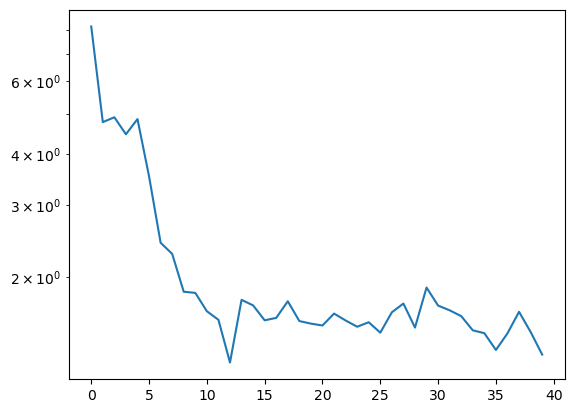

100%|██████████| 2000/2000 [00:32<00:00, 62.31it/s]


In [224]:
from tqdm import trange

model = CouplingFlow(num_coupling_blocks=5)
criterion = RealNVPLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
batch_size = 10

epochs = 2000
log_interval = 50

losses_train = []
for epoch in trange(epochs):
    samples = prior.sample([50])
    loss_train = train_BG(samples, model, optimizer, criterion)

    if epoch % log_interval == 0:
        print(f'Train Epoch: {epoch} Loss: {loss_train:.6f}')

        losses_train.append(loss_train)

        clear_output(wait=True)

        plt.plot(losses_train)
        plt.yscale('log')
        plt.show()

In [225]:
torch.save(model.state_dict(), "model_BG.torch")

## Reweight

In [16]:
model = CouplingFlow(num_coupling_blocks=5)
model.load_state_dict(torch.load("model_BG.torch"))

<All keys matched successfully>

In [34]:
beta = 3.0

def log_weights_given_latent(prior_samples, flow):
    mapped_samples, ldj = flow.forward(prior_samples)
    ldj = ldj.view(-1)
    print(f"{mapped_samples.shape=}")
    print(f"{ldj.shape=}")
    print(f"{ldj=}")
    prior_energy  = - prior.log_prob(prior_samples).sum(axis=-1)
    print(f"{prior_energy.shape=}")
    target_energy = Vpot(mapped_samples)
    print(f"{prior_energy.shape=}")

    logw = prior_energy - beta * target_energy + ldj
    print(f"{logw.shape=}")

    return logw.view(-1)

''' the original sample size divided by the design effect to reflect
 the variance from the current sampling design as compared to what would be 
 if the sample was a simple random sample'''
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0))

## MD Data

In [18]:
md_data = torch.from_numpy(np.load("traj_2d_potential.npy"))
md_energies = Vpot(md_data)


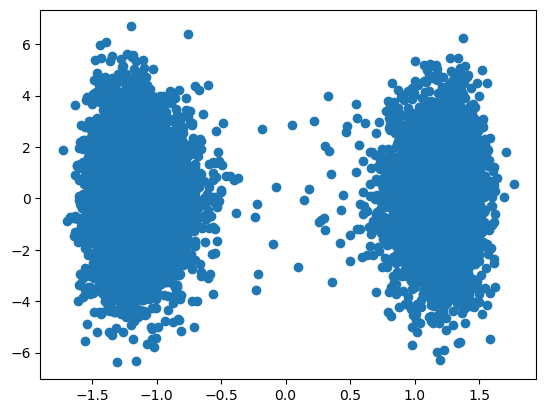

In [19]:
plt.scatter(md_data[:,0], md_data[:,1]);

In [35]:
samples = prior.sample([5000])
with torch.no_grad():
    mapped_samples, ldj = model.forward(samples)

In [36]:
log_weights=0
with torch.no_grad():
    log_weights = log_weights_given_latent(samples, model)
    mapped_energy = Vpot(model.forward(samples)[0])

mapped_samples.shape=torch.Size([5000, 2])
ldj.shape=torch.Size([5000])
ldj=tensor([-0.8604, -0.3027, -1.1391,  ..., -0.8114,  0.2858, -0.7878])
prior_energy.shape=torch.Size([5000])
prior_energy.shape=torch.Size([5000])
logw.shape=torch.Size([5000])


In [37]:
print(mapped_energy.shape)
print(log_weights.shape)

torch.Size([5000])
torch.Size([5000])


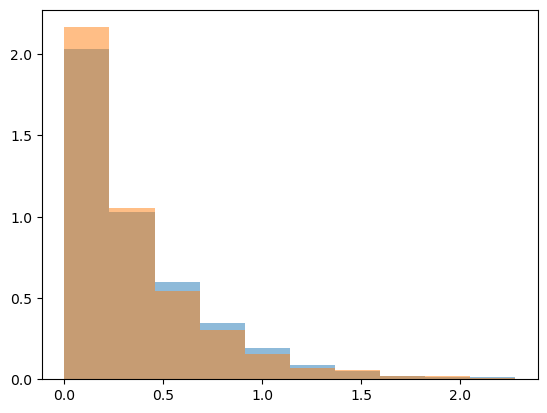

In [38]:
plt.hist(mapped_energy,alpha=.5, density=True);
plt.hist(mapped_energy,weights =log_weights.exp().detach().numpy(),alpha=.5, density=True);


In [39]:
ess_flow = effective_sample_size(log_weights)
ess_flow / 5000

tensor(0.8823)

In [41]:
mapped_samples[:,0]

tensor([ 1.3038,  1.1460,  1.5785,  ...,  1.2222, -1.1719,  1.2206])

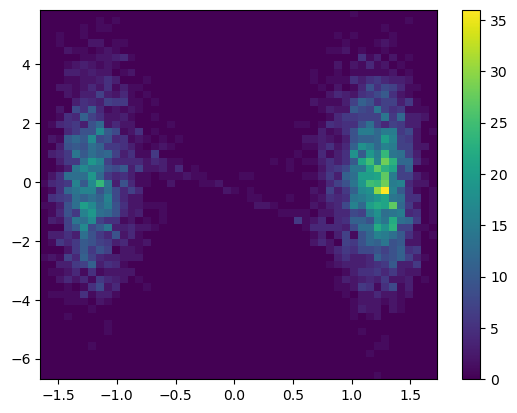

In [49]:

plt.hist2d(mapped_samples[:,0].tolist(), mapped_samples[:,1].tolist(), bins=50);
plt.colorbar()
# plt.hist2d(mapped_samples[:,0].tolist(), mapped_samples[:,1].tolist(), bins=50, weights=log_weights .exp().detach().numpy())

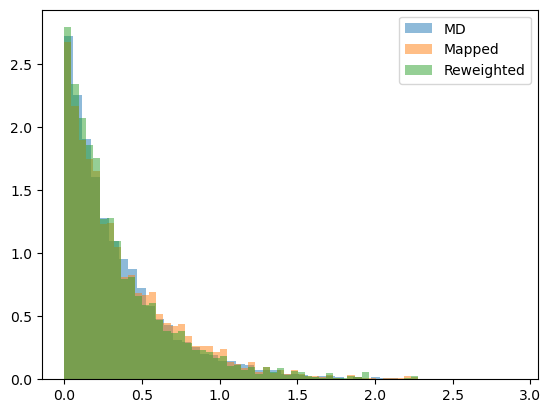

In [43]:
plt.hist(md_energies.detach().numpy(),alpha=.5,density=True, bins=50,label="MD")
plt.hist(mapped_energy, alpha=.5, density=True, bins=50,label="Mapped");
plt.hist(mapped_energy,weights =log_weights .exp().detach().numpy(),alpha=.5, density=True, bins=50,label="Reweighted");
plt.legend()
plt.show()

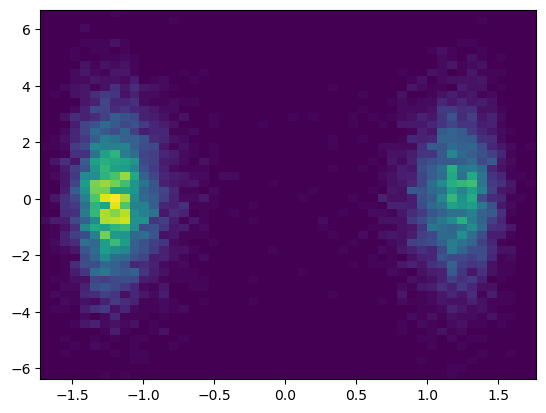

In [44]:

plt.hist2d(md_data[:,0].tolist(), md_data[:,1].tolist(), bins=50);